In [485]:
import json
import csv
import os
import re

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, LinearConstraint, curve_fit
import skrf as rf
import qutip as qt
import scqubits as scq

# 1. Q1-C1

## 1.1 Vector Fitting

### 1.1.1 Import Admittance Data

In [529]:
admittance_directory = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Microwave Office\measurement_graphs'

number_of_ports = 2

y_filepath = os.path.join(admittance_directory, 'q1_coupler.txt')

frequencies = []
admittances = []

# regex to find matrix element index
matrix_element_regex = re.compile(r"Im\(Y\((?P<i>\d),(?P<j>\d).*")

# determine number of data points
counter = 0
with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        counter += 1
        
y_matrix = np.empty((counter-1, number_of_ports, number_of_ports), dtype='complex')

with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    
    
    i = 0
    for row in reader:
        if i == 0:
            headers = row[1:]
            matrix_element_order = []
            
            for header in headers:
            
                match = matrix_element_regex.search(header)
                groupdict = match.groupdict()
                matrix_element_order.append((int(groupdict['i'])-1, int(groupdict['j'])-1))
            
        elif i > 0:
            frequency = float(row[0])
            frequencies.append(frequency)
            
            for j, value in enumerate(row[1:]):
                
                index_1, index_2 = matrix_element_order[j]
                
                y_matrix[i-1, index_1, index_2] = 1j*float(value)
                
                if index_1 != index_2:
                    y_matrix[i-1, index_2, index_1] = 1j*float(value)
            
        i += 1
        
frequencies = np.array(frequencies)


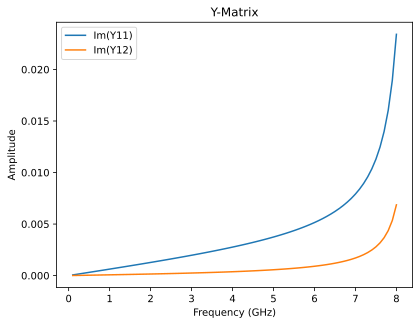

In [530]:
# plot admittances

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i == number_of_ports - 1 and j == number_of_ports - 1:
            continue
        
        if i <= j:
            plt.plot(frequencies, np.imag(y_matrix[:, i, j]), label=f'Im(Y{i+1}{j+1})')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y-Matrix')

plt.show()

### 1.1.2 Fit Raw Data to Pole Model

In [531]:
frequencies_Hz = frequencies * 1e9
network = rf.Network(frequency=frequencies_Hz, y=y_matrix)
vector_fit = rf.VectorFitting(network)

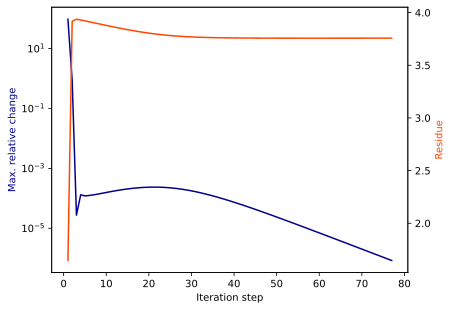

RMS error y11 = 6.003297967788386e-05
RMS error y12 = 2.1073754748800712e-05
RMS error y22 = 0.0002428726785998583


In [532]:
vector_fit.vector_fit(n_poles_real=1, n_poles_cmplx=2, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.plot_convergence()
plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')


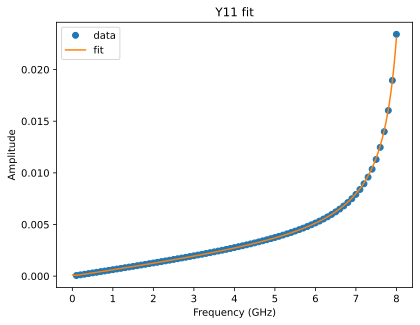

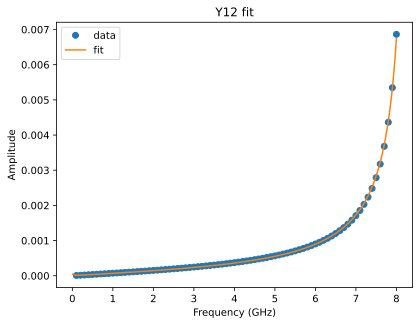

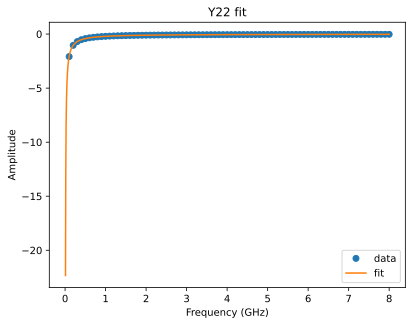

In [533]:
# plot all fits

fit_model_frequencies = np.linspace(0.01e9, 8e9, 10000)

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, fit_model_frequencies)


            # Yij
            plt.plot(frequencies, np.imag(y_matrix[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(fit_model_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')

            plt.legend()

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()
            

### 1.1.3 Optimize Y33 Subtraction

In [521]:
def inductive_model(L, frequencies):
    return 1/(1j * frequencies * 1e9 * 2 * np.pi * L * 1e-9)

In [522]:
def cost_function(x, frequencies, y33_data, max_index):
    return np.linalg.norm((np.imag(inductive_model(x, frequencies)[:max_index] - y33_data[:max_index])))

In [534]:
inductive_model_max_frequency = 1
index = int(inductive_model_max_frequency / (frequencies[-1] - frequencies[0]) * len(frequencies))
print(index)
print(frequencies[index])

10
1.1


In [535]:
bounds = (0, 100)
args = frequencies, y_matrix[:,-1,-1], index
result = minimize_scalar(cost_function, bounds=bounds, args=args)

In [536]:
loop_self_inductance = result.x
print(f'couper loop self inductance: {loop_self_inductance} nH')

couper loop self inductance: 0.7646513988577626 nH


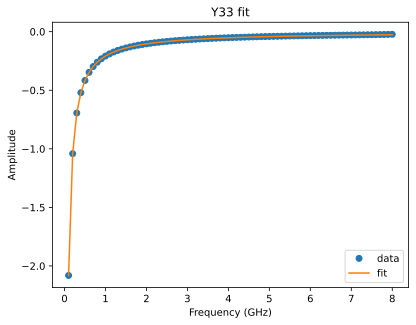

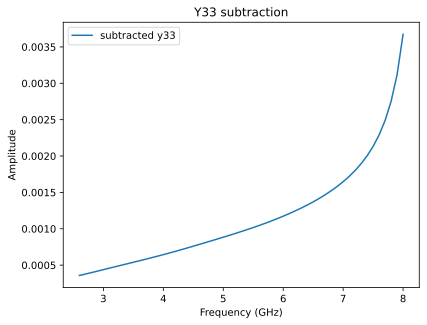

In [537]:
plt.plot(frequencies, np.imag(y_matrix[:,-1,-1]), linestyle='', marker='o', label='data')
plt.plot(frequencies, np.imag(inductive_model(result.x, frequencies)), label='fit')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y33 fit')
plt.show()

start_index = 25

# difference
plt.plot(frequencies[start_index:], np.imag(y_matrix[start_index:,-1,-1] - inductive_model(result.x, frequencies)[start_index:]), label='subtracted y33')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y33 subtraction')
plt.show()

### 1.1.4 Fit With Y33 Subtraction

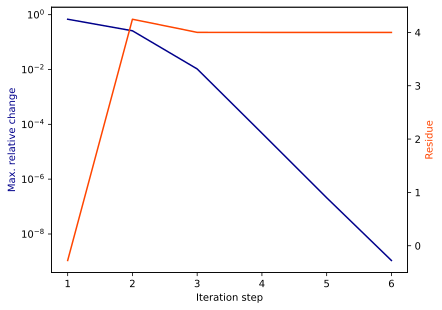

RMS error y11 = 7.97573134387473e-06
RMS error y12 = 3.143659446570264e-06
RMS error y22 = 5.969593181770658e-05


In [538]:
y33_subtracted = y_matrix[:,-1,-1] - inductive_model(result.x, frequencies)

y_matrix_subtracted = np.copy(y_matrix)
y_matrix_subtracted[:,-1,-1] = y33_subtracted[:]

y_matrix_subtracted_cutoff = y_matrix_subtracted[index:, :, :]

cutoff_frequencies = frequencies[index:]
network = rf.Network(frequency=cutoff_frequencies*1e9, y=y_matrix_subtracted_cutoff)
vector_fit = rf.VectorFitting(network)


# vector_fit.vector_fit(n_poles_real=1, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)

vector_fit.plot_convergence()

plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')



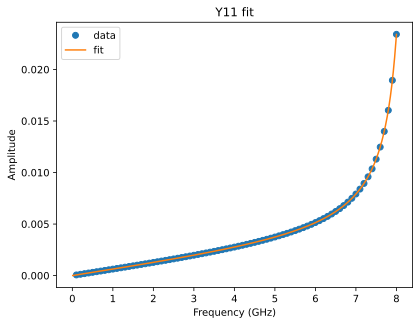

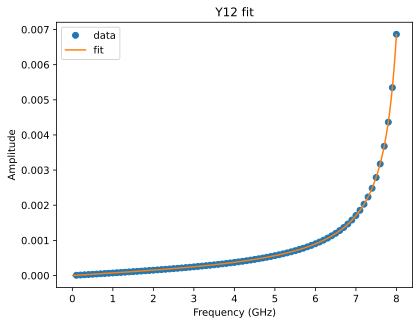

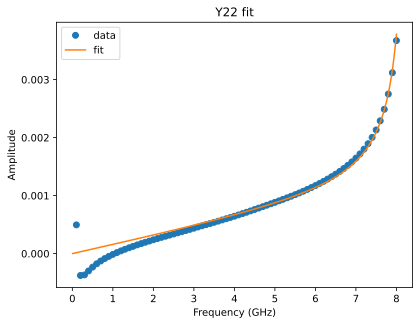

In [539]:
fit_model_frequencies = np.linspace(0.01e9, 8e9, 10000)


for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, fit_model_frequencies)


            # Yij
            plt.plot(frequencies, np.imag(y_matrix_subtracted[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(fit_model_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')

            plt.legend()
            
#             if (i, j) == (0, 1):
#                 plt.xlim(0, 0.5)
#                 plt.ylim(-0.00001, 0.00001)

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()

### 1.1.5 Test redoing fit with poles in frequency range

In [499]:
poles = vector_fit.poles
pole_frequency = poles[0].imag/(2*np.pi)/1e9 # GHz
print(pole_frequency)

new_frequencies = np.linspace(0, pole_frequency*1.2, 1001)*1e9

8.365655395069664


(1001, 2, 2)


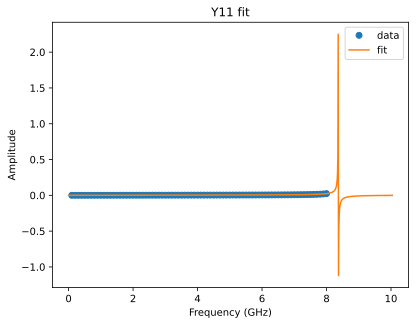

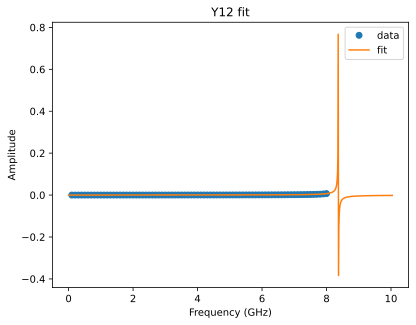

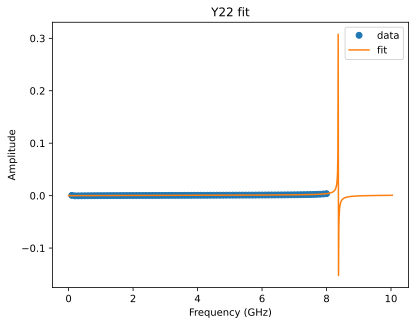

In [500]:
new_y_matrix = np.zeros((len(new_frequencies), *y_matrix.shape[1:]), dtype='complex')
print(new_y_matrix.shape)

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
            model_yij = vector_fit.get_model_response(i, j, new_frequencies)
            new_y_matrix[:, i, j] = model_yij

            if i <= j:
                # Yij
                plt.plot(frequencies, np.imag(y_matrix_subtracted[:,i,j]), linestyle='', marker='o', label='data')
                plt.plot(new_frequencies/1e9, np.imag(model_yij), label='fit')

                plt.xlabel('Frequency (GHz)')
                plt.ylabel('Amplitude')

                plt.legend()

    #             if (i, j) == (0, 1):
    #                 plt.xlim(0, 0.5)
    #                 plt.ylim(-0.00001, 0.00001)

                plt.title(f'Y{i+1}{j+1} fit')
                plt.show()

0
0.0


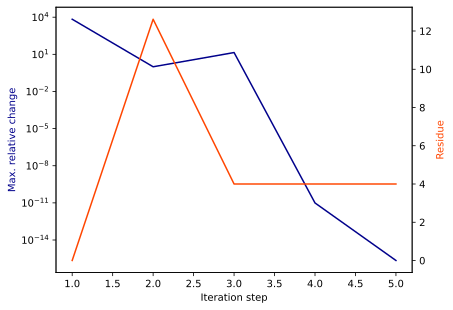

RMS error y11 = 9.70469801806105e-15
RMS error y12 = 3.015080645262633e-15
RMS error y22 = 1.214128226266111e-15


In [501]:
# fit with new y data

start_frequency = 1
index = int(start_frequency / (new_frequencies[-1] - new_frequencies[0]) * len(new_frequencies))
print(index)
print(new_frequencies[index])

new_y_matrix_cutoff = new_y_matrix[index:, :, :]

cutoff_frequencies = new_frequencies[index:]
network = rf.Network(frequency=cutoff_frequencies, y=new_y_matrix)
vector_fit = rf.VectorFitting(network)

vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)

vector_fit.plot_convergence()

plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')

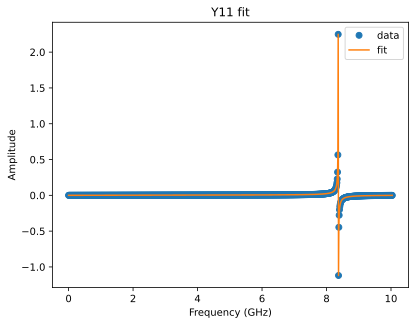

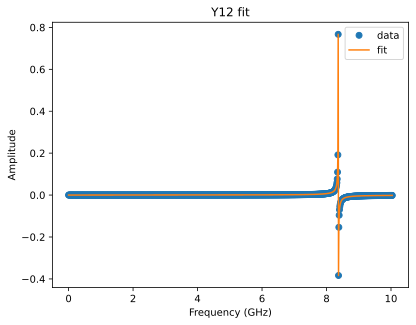

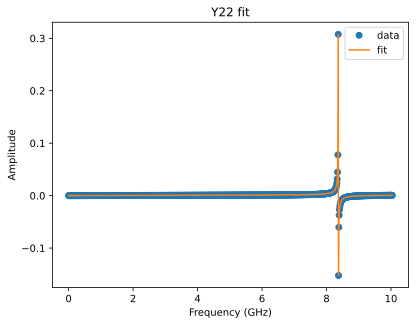

In [502]:
for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, new_frequencies)


            # Yij
            plt.plot(new_frequencies/1e9, np.imag(new_y_matrix[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(new_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')

            plt.legend()
            
#             if (i, j) == (0, 1):
#                 plt.xlim(0, 0.5)
#                 plt.ylim(-0.00001, 0.00001)

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()

### 1.1.6 Test redoing fit with larger frequency range in MWO

In [503]:
admittance_directory = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Microwave Office\measurement_graphs'

number_of_ports = 2

y_filepath = os.path.join(admittance_directory, 'q1_coupler_wider_range.txt')

frequencies = []
admittances = []

# regex to find matrix element index
matrix_element_regex = re.compile(r"Im\(Y\((?P<i>\d),(?P<j>\d).*")

# determine number of data points
counter = 0
with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        counter += 1
        
y_matrix = np.empty((counter-1, number_of_ports, number_of_ports), dtype='complex')

with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    
    
    i = 0
    for row in reader:
        if i == 0:
            headers = row[1:]
            matrix_element_order = []
            
            for header in headers:
            
                match = matrix_element_regex.search(header)
                groupdict = match.groupdict()
                matrix_element_order.append((int(groupdict['i'])-1, int(groupdict['j'])-1))
            
        elif i > 0:
            frequency = float(row[0])
            frequencies.append(frequency)
            
            for j, value in enumerate(row[1:]):
                
                index_1, index_2 = matrix_element_order[j]
                
                y_matrix[i-1, index_1, index_2] = 1j*float(value)
                
                if index_1 != index_2:
                    y_matrix[i-1, index_2, index_1] = 1j*float(value)
            
        i += 1
        
frequencies = np.array(frequencies)


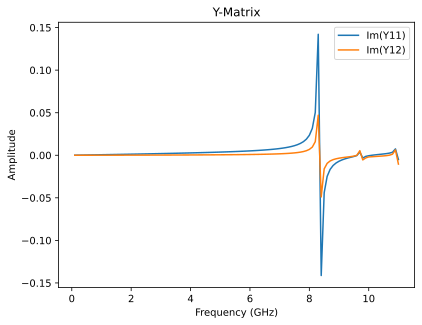

In [504]:
# plot admittances

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i == number_of_ports - 1 and j == number_of_ports - 1:
            continue
        
        if i <= j:
            plt.plot(frequencies, np.imag(y_matrix[:, i, j]), label=f'Im(Y{i+1}{j+1})')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y-Matrix')

plt.show()

In [505]:
frequencies_Hz = frequencies * 1e9
network = rf.Network(frequency=frequencies_Hz, y=y_matrix)
vector_fit = rf.VectorFitting(network)

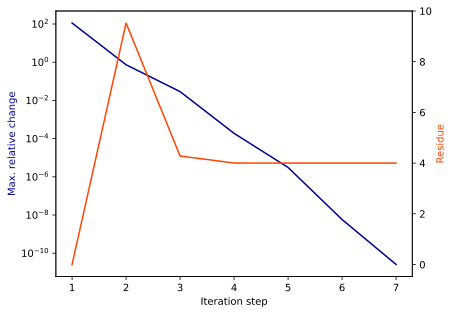

RMS error y11 = 0.0010483532299367132
RMS error y12 = 0.0014217501890510884
RMS error y22 = 0.0021370513301010685


In [506]:
vector_fit.vector_fit(n_poles_real=1, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.plot_convergence()
plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')


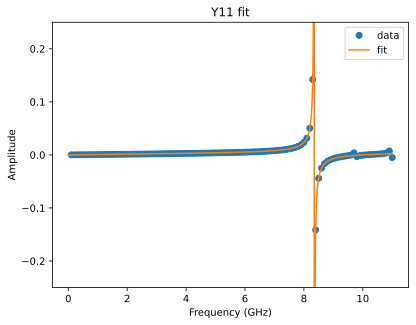

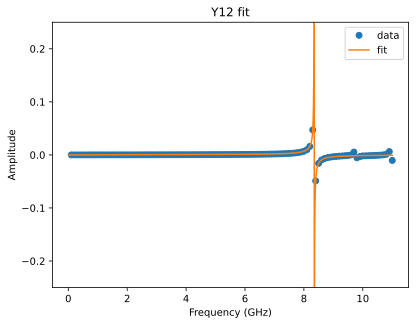

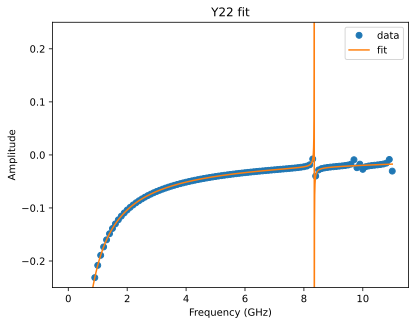

In [507]:
# plot all fits

fit_model_frequencies = np.linspace(0.01e9, 11e9, 10000)

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, fit_model_frequencies)


            # Yij
            plt.plot(frequencies, np.imag(y_matrix[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(fit_model_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')

            plt.ylim(-0.25, 0.25)
            
            plt.legend()

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()
            

In [508]:
inductive_model_max_frequency = 1
index = int(inductive_model_max_frequency / (frequencies[-1] - frequencies[0]) * len(frequencies))
print(index)
print(frequencies[index])

10
1.1


In [509]:
bounds = (0, 100)
args = frequencies, y_matrix[:,-1,-1], index
result = minimize_scalar(cost_function, bounds=bounds, args=args)

In [510]:
loop_self_inductance = result.x
print(f'couper loop self inductance: {loop_self_inductance} nH')

couper loop self inductance: 0.7646470276370215 nH


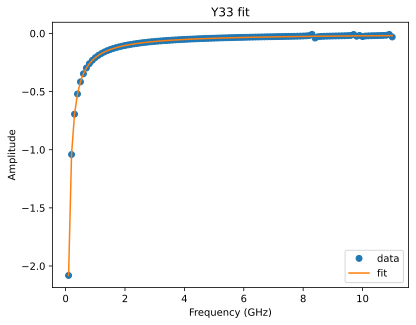

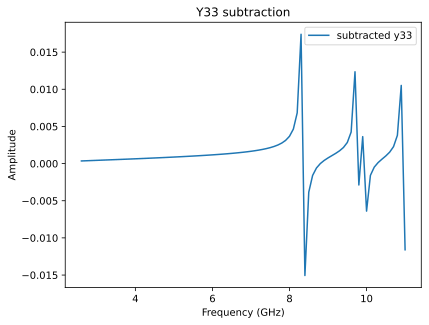

In [511]:
plt.plot(frequencies, np.imag(y_matrix[:,-1,-1]), linestyle='', marker='o', label='data')
plt.plot(frequencies, np.imag(inductive_model(result.x, frequencies)), label='fit')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y33 fit')
plt.show()

start_index = 25

# difference
plt.plot(frequencies[start_index:], np.imag(y_matrix[start_index:,-1,-1] - inductive_model(result.x, frequencies)[start_index:]), label='subtracted y33')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y33 subtraction')
plt.show()

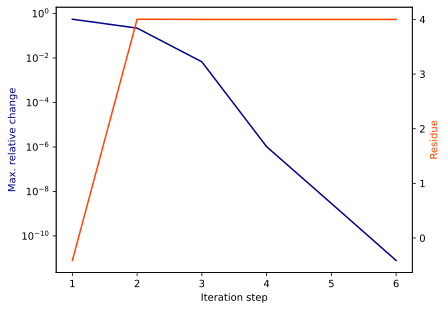

RMS error y11 = 0.0010979702150543899
RMS error y12 = 0.0014911087467819955
RMS error y22 = 0.002238883847711131


In [512]:
y22_subtracted = y_matrix[:,-1,-1] - inductive_model(result.x, frequencies)

y_matrix_subtracted = np.copy(y_matrix)
y_matrix_subtracted[:,-1,-1] = y22_subtracted[:]

y_matrix_subtracted_cutoff = y_matrix_subtracted[index:, :, :]

cutoff_frequencies = frequencies[index:]
network = rf.Network(frequency=cutoff_frequencies*1e9, y=y_matrix_subtracted_cutoff)
vector_fit = rf.VectorFitting(network)


# vector_fit.vector_fit(n_poles_real=1, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)

vector_fit.plot_convergence()

plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')



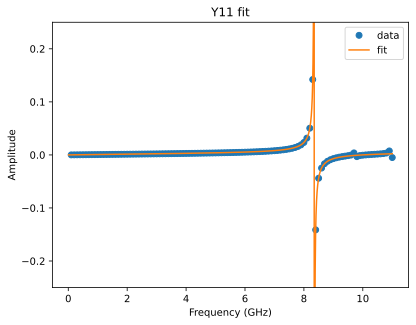

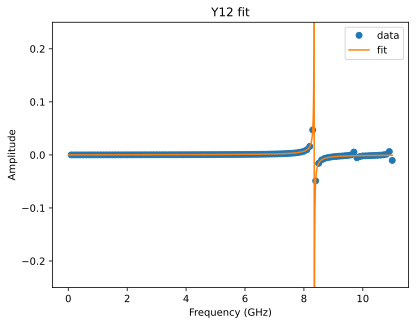

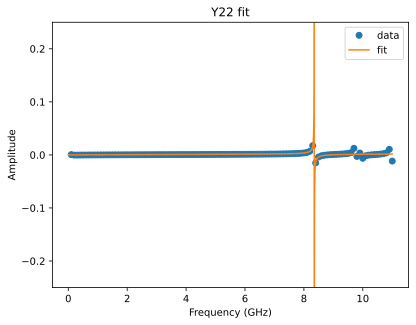

In [513]:
fit_model_frequencies = np.linspace(0.01e9, 11e9, 10000)


for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, fit_model_frequencies)


            # Yij
            plt.plot(frequencies, np.imag(y_matrix_subtracted[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(fit_model_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')
            
            plt.ylim(-0.25, 0.25)

            plt.legend()
            
#             if (i, j) == (0, 1):
#                 plt.xlim(0, 0.5)
#                 plt.ylim(-0.00001, 0.00001)

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()

### 1.1.7 Test Admittance Model Equation

In [560]:
# put residues into NxN matrices where N is number of ports
number_of_poles = 1

print(residues.shape)
print(number_of_poles)

# complex pole
if number_of_poles > 1:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports, number_of_poles)))
else:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports)))
    
proportional_coeff_reshaped = np.real(np.reshape(vector_fit.proportional_coeff, (number_of_ports, number_of_ports)))

pole_guess_Hz = 8.3656554 * 1e9
    
print()
print('Residue from complex poles')
print(residues_reshaped)

print()
print('Proportional coefficient')
print(proportional_coeff_reshaped)

(4, 1)
1

Residue from complex poles
[[47216888.23734259 16130332.4063456 ]
 [16130332.40634561  6446689.90079859]]

Proportional coefficient
[[ 6.58198583e-14 -1.89970747e-16]
 [-1.89970747e-16  2.06463899e-14]]


In [562]:
def admittance_model_function(frequencies, pole_frequency, prop_coeff, residues, i, j):
    '''
    assume one complex pole
    '''
    omega = frequencies * 2 * np.pi
    s = 1j * omega
    
    omega_k = pole_frequency * 2 * np.pi
    
    Y = s*prop_coeff[i, j] + 2*s*residues[i, j]/(np.power(s, 2) + np.power(omega_k, 2))
#     Y = s*prop_coeff[i, j] + residues[i, j]/(s - 1j*omega_k)
    
    return Y
    

Y00


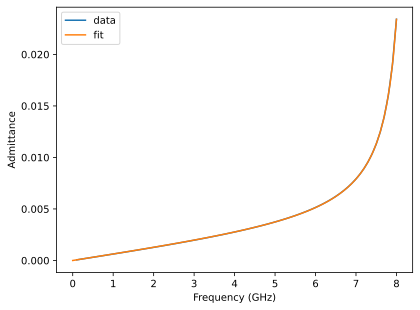

Y01


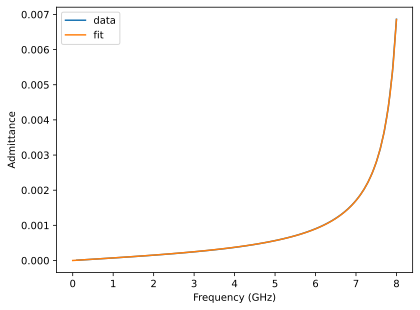

Y11


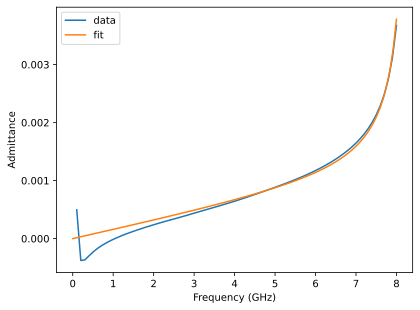

In [563]:
model_frequencies = np.linspace(0, 8, 101) * 1e9

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            y_ij = admittance_model_function(model_frequencies, pole_guess_Hz, proportional_coeff_reshaped, residues_reshaped, i, j)

            print(f'Y{i}{j}')
            plt.plot(frequencies, y_matrix_subtracted[:, i, j].imag, label='data')
            plt.plot(model_frequencies/1e9, y_ij.imag, label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Admittance')

            plt.legend()
            
            plt.show()


## 1.2 Circuit Parameters

In [555]:
# put residues into NxN matrices where N is number of ports
residues = vector_fit.residues
number_of_poles = len(vector_fit.poles)

print(residues.shape)
print(number_of_poles)

# complex pole
if number_of_poles > 1:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports, number_of_poles)))
else:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports)))
    
print()
print('Residue from complex poles')
print(residues_reshaped)

(4, 1)
1

Residue from complex poles
[[47216888.23734259 16130332.4063456 ]
 [16130332.40634561  6446689.90079859]]


In [556]:
# perform SVD on each NxN residue matrix

# complex pole

# len is number of poles, elements are M NxN rank 1 matrices where M is the rank of the original NxN residue matrix 
r_vectors = []
ranks = []

# if true, only consider the residue of the largest singular value
keep_only_largest_singular_value = False

for k in range(number_of_poles):
    
    if number_of_poles > 1:
        residue = residues_reshaped[:,:,k]
    else:
        residue = residues_reshaped
    
    rank = np.linalg.matrix_rank(residue)

    U, S, V = np.linalg.svd(residue)
    
    print(S)
    
    if keep_only_largest_singular_value:
        rank = 1
        
        r_vectors_k = np.zeros((rank, number_of_ports))
        r_vectors_k[0, :] = np.sqrt(2*np.max(S))*U[:,rank_index]
    else:

        r_vectors_k = np.zeros((rank, number_of_ports))

        for rank_index in range(rank):
            r_vectors_k[rank_index, :] = np.sqrt(2*S[rank_index])*U[:,rank_index]

    ranks.append(rank)
    r_vectors.append(r_vectors_k)
        
        
max_rank = np.max(ranks)
print(ranks)
for r_vector_k in r_vectors:
    print(r_vector_k.shape)

[52826786.50395192   836791.63418926]
[2]
(2, 2)


In [557]:
[52826786.50395261   836791.63418927]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (691522184.py, line 1)

In [558]:
print(f'number of ports: {number_of_ports}')
print(f'number of poles: {number_of_poles}')
print(f'max rank: {max_rank}')

number of ports: 2
number of poles: 1
max rank: 2


In [559]:
# define circuit parameters for complex pole

# total capacitances C_k
C_k = 20e-15 # F
C_ks = np.array([C_k]*number_of_poles*max_rank) 
C_ks = np.reshape(C_ks, (number_of_poles, max_rank))


# pole frequency omega_k
omega_ks = np.imag(vector_fit.poles) # Hz * 2pi

frequency_ks = omega_ks/2/np.pi # Hz

# print(f'pole 2 frequency: {frequency_2} GHz')
print(f'\nPole frequencies: {frequency_ks/1e9} GHz')


# pole inductance L_k
print(f'\nMode inductances (nH)')
L_ks = np.zeros((number_of_poles, max_rank))
for k in range(number_of_poles):
    L_ks[k,:] = 1/(omega_ks[k]**2*C_ks[k,:]) # H

    print(f'\tpole {k}: {L_ks[k,:] * 1e9}')


# Coupling capacitances [C_ki]_j = sqrt(C_k)/(omega_k) [r_ki]_j

C_coupling_ks = np.zeros((number_of_poles, max_rank, number_of_ports))

print('\nCoupling capacitances (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_coupling_ks[k, rank_index, :] = np.sqrt(C_ks[k, rank_index])/omega_ks[k] * r_vectors[k][rank_index, :]


        print(f'\tpole {k}, rank index {rank_index}: {C_coupling_ks[k, rank_index, :] * 1e15}')


# capacitance to ground C_kig = C_k - sum_j [C_ki]_j
C_g_ks = np.zeros((number_of_poles, max_rank))

print('\nPole capacitance to ground (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_g_ks[k, rank_index] = C_ks[k, rank_index] - np.sum(C_coupling_ks[k, rank_index, :])
        
        print(f'\tpole {k}, rank index {rank_index}: {C_g_ks[k, rank_index] * 1e15} fF')


# fit proportional capacitance C_n
C_n = np.reshape(vector_fit.proportional_coeff, (number_of_ports, number_of_ports)) # F
print(f'\nproportional coefficients (fF): \n{C_n * 1e-15}')


Pole frequencies: [8.3656554] GHz

Mode inductances (nH)
	pole 0: [18.09715583 18.09715583]

Coupling capacitances (fF)
	pole 0, rank index 0: [-26.1206025   -9.08437092]
	pole 0, rank index 1: [-1.14334271  3.28749241]

Pole capacitance to ground (fF)
	pole 0, rank index 0: 55.20497342021136 fF
	pole 0, rank index 1: 17.855850301926782 fF

proportional coefficients (fF): 
[[ 6.58198583e-29 -1.89970747e-31]
 [-1.89970747e-31  2.06463899e-29]]


In [285]:
# define capacitance matrix

first_term = 0
second_term = 0
for k in range(number_of_poles):
    
    omega = omega_ks[k]
        
    if omega == 0:
        continue
    
    for rank_index in range(max_rank):
        
        r_vector = r_vectors[k][rank_index, :]
        
        first_term += np.outer(r_vector, r_vector)/(omega**2)
        
        second_term += - np.sqrt(C_ks[k, rank_index])/omega * np.diag(r_vector)


cap_matrix = C_n + first_term + second_term

cap_matrix_fF = cap_matrix * 1e15

print('Capacitance Matrix (fF)')
print(cap_matrix_fF)

# analyze capacitance matrix to get capacitances to ground

capacitance_to_grounds = np.sum(cap_matrix, -1)
print(f'\nNode capacitance to grounds: {capacitance_to_grounds * 1e15} fF')

Capacitance Matrix (fF)
[[127.2634589   11.48655482]
 [ 11.48655482  31.10993849]]

Node capacitance to grounds: [138.75001372  42.59649331] fF


## 1.3 ScQubits

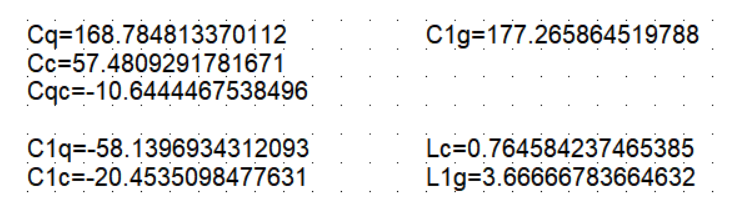

In [346]:
### run this to use circuit parameters taken from MWO (one pole fit)

number_of_poles = 1
max_rank = 1

circuit_parameters = {}

circuit_parameters[f'pole_inductance_0'] = 3.66666783664632
circuit_parameters[f'pole_capacitance_ground_0'] = 177.265864519788
circuit_parameters[f'coupling_capacitance_0_0'] = -58.1396934312093
circuit_parameters[f'coupling_capacitance_0_1'] = -20.4535098477631

circuit_parameters[f'node_capacitance_ground_0'] = 168.784813370112
circuit_parameters[f'node_capacitance_ground_1'] = 57.4809291781671
circuit_parameters[f'internode_capacitance_01'] = -10.6444467538496
circuit_parameters['coupler_inductance'] = 0.764584237465385

In [286]:
### run this to use circuit parameters from vector fitting
number_of_poles = len(vector_fit.poles)
max_rank = np.max(ranks)

circuit_parameters = {}

for k in range(number_of_poles):
    for rank_index in range(max_rank):
        circuit_parameters[f'pole_inductance_{k*max_rank + rank_index}'] = L_ks[k, rank_index] * 1e9 # nH
        circuit_parameters[f'pole_capacitance_ground_{k*max_rank + rank_index}'] = C_g_ks[k, rank_index] * 1e15 # fF
        
        for i in range(number_of_ports):
            circuit_parameters[f'coupling_capacitance_{k*max_rank + rank_index}_{i}'] = C_coupling_ks[k, rank_index, i] * 1e15 # fF

for i in range(number_of_ports):
    
    circuit_parameters[f'node_capacitance_ground_{i}'] = capacitance_to_grounds[i] * 1e15 # fF
    
    for j in range(number_of_ports):
        
        if i != j:
            circuit_parameters[f'internode_capacitance_{i}{j}'] = -cap_matrix_fF[i, j] # fF
            
circuit_parameters['coupler_inductance'] = loop_self_inductance
            
            
for key, value in circuit_parameters.items():
    print(f'{key}: {value}')

pole_inductance_0: 18.097155830592698
pole_capacitance_ground_0: 55.20497342021136
coupling_capacitance_0_0: -26.12060249806845
coupling_capacitance_0_1: -9.084370922142915
pole_inductance_1: 18.097155830592698
pole_capacitance_ground_1: 17.855850301926782
coupling_capacitance_1_0: -1.1433427095123099
coupling_capacitance_1_1: 3.28749240758553
node_capacitance_ground_0: 138.75001371757884
internode_capacitance_01: -11.486554819724544
node_capacitance_ground_1: 42.596493307863625
internode_capacitance_10: -11.486554819724544
coupler_inductance: 0.7646513988577626


### 1.3.1 Create circuit yaml

In [347]:
def create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances, loop_phase=0):
    
    yaml_str = 'branches:'
    
    total_num_poles = num_poles * num_ranks
    num_nodes = 1 + num_ports + total_num_poles
    
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # add capacitances
            capacitance = None
    
            if i == 0:
                # ground to everything (capacitances)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'node_capacitance_ground_{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'pole_capacitance_ground_{j - 1 - num_ports}']
                    
                    inductance = circuit_parameters[f'pole_inductance_{j - 1 - num_ports}']
                    yaml_str += f'\n- ["L", {i}, {j}, {inductance}nH]'
                    
            elif i in range(1, 1 + num_ports):
                # q1, q2, c to everything (capacitance)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'internode_capacitance_{i - 1}{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'coupling_capacitance_{j - 1 - num_ports}_{i - 1}']
            
            if not capacitance is None:
                yaml_str += f'\n- ["C", {i}, {j}, {capacitance}fF]'
                
    # junctions: [EJ_q1, EJ_q2, EJ_c]
    EJ_q1, EJ_c = junction_EJs
    
    # parasitic capacitances: [C_parasitic_q1, C_parasitic_q2, C_parasitic_c]
    C_parasitic_q1, C_parasitic_c = parasitic_capacitances
    
    # coupler inductance
    L_loop = circuit_parameters['coupler_inductance']
                
    # add junctions and coupler inductor
    
    yaml_str += f'\n- ["JJ", 0, 1, EJ_q1 = {EJ_q1}, {C_parasitic_q1}fF]'
    yaml_str += f'\n- ["JJ", 0, 2, EJ_c = {EJ_c}, C_parasitic_c = {C_parasitic_c}fF]'
    yaml_str += f'\n- ["L", 0, 2, {L_loop}nH]'
    
    return yaml_str
                    

In [348]:
# define junction parameters

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi0 = h/(2*e)

# qubit 1 
EJ_q1 = 20 # GHz
EJ_q1_J = EJ_q1 * h # J

L_J1 = (Phi0/(2*np.pi))**2/EJ_q1_J # nH
# L_J = L_J_H * 1e9 # nH

C_parasitic_q = 12 # fF

# coupler
EJ_c = 195 # GHz
EJ_c_J = EJ_c * h # J

L_c0 = (Phi0/(2*np.pi))**2/EJ_c_J # nH
# L_c0 = L_c0_H * 1e9 # nH

C_parasitic_c = 51.81966507 # fF

print(f'Qubit 1 junction inductance: {L_J1} nH')

print(f'Coupler junction inductance: {L_c0} nH')

frequency_estimate1 = 1/np.sqrt(L_J1 * 129.5)/(2*np.pi)*1e6
frequency_estimate2 = 1/np.sqrt(L_J2 * 132.8)/(2*np.pi)*1e6

print(f'frequency estimate Q1: {frequency_estimate1} MHz')



Qubit 1 junction inductance: 8.195241245289674 nH
Coupler junction inductance: 0.8405375636194536 nH
frequency estimate Q1: 4885.447787307838 MHz


In [349]:
# check what EJ corresponds to a coupler inductance

L_c0_impedance_response = 0.638 # nH
L_c0_impedance_response = loop_self_inductance
EJ_c_impedance_response = (Phi0/(2*np.pi))**2/L_c0_impedance_response/h

print(f'EJ from impedance response formula: {EJ_c_impedance_response}')

EJ from impedance response formula: 214.35235082370184


In [350]:
junction_EJs = (EJ_q1, EJ_c)
parasitic_capacitances = (C_parasitic_q, C_parasitic_c)

circuit_yaml = create_circuit_yaml(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

In [351]:
print(circuit_yaml)

branches:
- ["C", 0, 1, 168.784813370112fF]
- ["C", 0, 2, 57.4809291781671fF]
- ["L", 0, 3, 3.66666783664632nH]
- ["C", 0, 3, 177.265864519788fF]
- ["C", 1, 2, -10.6444467538496fF]
- ["C", 1, 3, -58.1396934312093fF]
- ["C", 2, 3, -20.4535098477631fF]
- ["JJ", 0, 1, EJ_q1 = 20, 12fF]
- ["JJ", 0, 2, EJ_c = 195, C_parasitic_c = 51.81966507fF]
- ["L", 0, 2, 0.764584237465385nH]


### 1.3.2 Analyze Circuit

In [354]:
def create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances, phase=0):   
    circuit_yaml = create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    circuit = scq.Circuit(circuit_yaml, from_file=False, ext_basis='harmonic', basis_completion='canonical')

    circuit.configure(np.identity(num_poles*num_ranks + num_ports))
#     circuit.variable_transformation()

    circuit.cutoff_n_1 = 20
    circuit.cutoff_ext_2 = 25
    circuit.cutoff_ext_3 = 20
#     circuit.cutoff_ext_4 = 20
    
    circuit.Φ1 = phase

    return circuit

In [355]:
junction_EJs = (EJ_q1, EJ_c)
parasitic_capacitances = (C_parasitic_q, C_parasitic_c)

circuit = create_circuit(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

In [356]:
print(f'var categories: {circuit.var_categories}')

var categories: {'periodic': [1], 'extended': [2, 3], 'free': [], 'frozen': [], 'sigma': []}


In [357]:
print(f'variable transformation')
print(circuit.transformation_matrix)
circuit.variable_transformation()

variable transformation
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


<IPython.core.display.Latex object>

In [358]:
print(f'Hamiltonian:')
circuit.sym_hamiltonian()

Hamiltonian:


<IPython.core.display.Latex object>

In [359]:
circuit.sym_external_fluxes()

{Φ1: (Branch(L, 0, 2, id_str: 9),
  [Branch(JJ, 0, 2, id_str: 8), Branch(L, 0, 2, id_str: 9)])}

In [360]:
circuit.variable_transformation()

<IPython.core.display.Latex object>

In [362]:
# set cutoff
circuit.cutoff_names

circuit.cutoff_n_1 = 20
circuit.cutoff_ext_2 = 10
circuit.cutoff_ext_3 = 25
# circuit.cutoff_ext_4 = 25


In [363]:
circuit.Φ1 = 0
evals = circuit.eigenvals(2)
q1_frequency = evals[1] - evals[0]
print(q1_frequency)

4.729158553384821


In [364]:
EJs = np.linspace(10, 30, 11)
spectrum_data = circuit.get_spectrum_vs_paramvals('EJ_c', EJs, evals_count=2, subtract_ground=True)

Spectral data:   0%|          | 0/11 [00:00<?, ?it/s]

(11, 2)


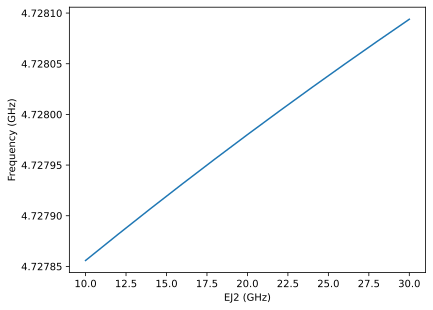

In [365]:
print(spectrum_data.energy_table.shape)
plt.plot(EJs, spectrum_data.energy_table[:,1])
# plt.plot(EJs, spectrum_data.energy_table[:,2])

plt.xlabel('EJ2 (GHz)')
plt.ylabel('Frequency (GHz)')

plt.show()

## 1.4 Parameter Sweeps

### 1.4.1 Sweep Qubit Ej

In [367]:
def sweep_qubit_EJ(qubit_EJs, circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):
    
    EJ_q1, EJ_c = junction_EJs
    
    
    frequency_data = np.zeros((len(qubit_EJs)))
    
#     circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    
    for i in range(len(qubit_EJs)):
        EJ_i = qubit_EJs[i]
        
        junction_EJs = EJ_i, EJ_c
        circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)

#         circuit.EJ_q1 = EJ_i
        
        print(EJ_i)
        
        evals = circuit.eigenvals(2)
        
        frequency_data[i] = evals[1] - evals[0]            
                
    return frequency_data

In [368]:
qubit_EJs = np.linspace(10, 50, 11) # GHz

junction_EJs = (EJ_q1, EJ_c)
parasitic_capacitances = (C_parasitic_q, C_parasitic_c)

frequency_data = sweep_qubit_EJ(qubit_EJs, circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

10.0
14.0
18.0
22.0
26.0
30.0
34.0
38.0
42.0
46.0
50.0


In [369]:
qubit_EJ_sweep_frequency_data = np.copy(frequency_data)

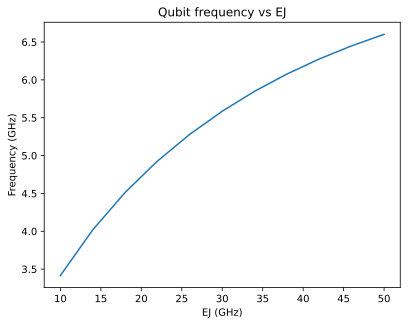

In [370]:
plt.plot(qubit_EJs, qubit_EJ_sweep_frequency_data)
# plt.plot(phases, frequency_data[:,1], label='Q2')

plt.xlabel('EJ (GHz)')
plt.ylabel('Frequency (GHz)')

plt.title('Qubit frequency vs EJ')

plt.show()

### 1.4.2 Sweep Qubit vs Coupler Phase

In [301]:
def sweep_fixed_qubit_frequency_vs_phase(phases, circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):
    
    EJ_q1, EJ_c = junction_EJs
    
    frequency_data = np.zeros((len(phases)))
    
    circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    
    for i in range(len(phases)):
        phase = phases[i]
        
        circuit.Φ1 = phase
        
        print(phase)
        
        evals = circuit.eigenvals(2)
        
        frequency_data[i] = evals[1] - evals[0]            
                
    return frequency_data

In [389]:
phases = np.linspace(0, 1, 51) # units of 2pi
phases = np.linspace(0.4, 0.6, 101) # units of 2pi

EJ_c_phase_sweep = 175 # GHz
junction_EJs = (EJ_q1, EJ_c_phase_sweep)
parasitic_capacitances = (C_parasitic_q, C_parasitic_c)

frequency_data = sweep_fixed_qubit_frequency_vs_phase(phases, circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

0.4
0.402
0.404
0.406
0.40800000000000003
0.41000000000000003
0.41200000000000003
0.41400000000000003
0.41600000000000004
0.41800000000000004
0.42000000000000004
0.42200000000000004
0.42400000000000004
0.42600000000000005
0.428
0.43
0.432
0.434
0.436
0.438
0.44
0.442
0.444
0.446
0.448
0.45
0.452
0.454
0.456
0.458
0.46
0.462
0.464
0.466
0.468
0.47000000000000003
0.472
0.474
0.476
0.478
0.48
0.482
0.484
0.486
0.488
0.49
0.492
0.494
0.496
0.498
0.5
0.502
0.504
0.506
0.508
0.51
0.512
0.514
0.516
0.518
0.52
0.522
0.524
0.526
0.528
0.53
0.532
0.534
0.536
0.538
0.54
0.542
0.544
0.546
0.548
0.55
0.552
0.554
0.556
0.558
0.56
0.562
0.5640000000000001
0.5660000000000001
0.568
0.57
0.572
0.574
0.576
0.578
0.58
0.582
0.584
0.586
0.588
0.59
0.592
0.594
0.596
0.598
0.6


In [390]:
fixed_qubit_sweep_frequency_data = np.copy(frequency_data)

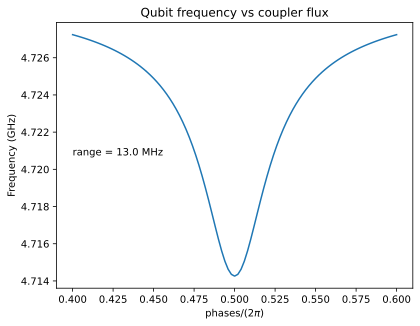

In [392]:
plt.plot(phases, fixed_qubit_sweep_frequency_data)
# plt.plot(phases, frequency_data[:,1], label='Q2')

plt.xlabel('phases/$(2\pi)$')
plt.ylabel('Frequency (GHz)')

plt.title('Qubit frequency vs coupler flux')

coupling_range = max(fixed_qubit_sweep_frequency_data) - min(fixed_qubit_sweep_frequency_data)
plt.text(0.4, min(fixed_qubit_sweep_frequency_data) + coupling_range/2, f'range = {round(coupling_range, 4)*1000} MHz')
# plt.text(0.455, min(fixed_qubit_sweep_frequency_data) + coupling_range/2, f'range = {round(coupling_range, 3)*1000} MHz')

plt.show()

In [393]:
print(max(fixed_qubit_sweep_frequency_data))
print(min(fixed_qubit_sweep_frequency_data))

4.727239220388782
4.714259040913618


In [395]:
(4.729 - 4.714)*1000

14.99999999999968